## Augmentations

In [1]:
from audiomentations import (
    AddGaussianNoise,
    TimeStretch,
    Shift,
    Gain,
    TanhDistortion,
    SevenBandParametricEQ,
    SevenBandParametricEQ,
    TimeMask,
    ApplyImpulseResponse,
)

from audiomentations.core.transforms_interface import BaseWaveformTransform
import parselmouth
import random

# import librosa
import numpy as np

# from random import random
import warnings
import math

PRAAT_CHANGEGENDER_PITCHMEDIAN_DEFAULT = 0.0
PRAAT_CHANGEGENDER_FORMANTSHIFTRATIO_DEFAULT = 1.0
PRAAT_CHANGEGENDER_PITCHSHIFTRATIO_DEFAULT = 1.0
PRAAT_CHANGEGENDER_PITCHRANGERATIO_DEFAULT = 1.0
PRAAT_CHANGEGENDER_DURATIONFACTOR_DEFAULT = 1.0


def aug(signal, augmentations_dict, override=False, sample_rate=44100):
    """Main augmentation function"""
    # Augment the signal

    sig_aug = signal
    # If its not false it is a dict containing manual transforms to apply
    if override is not False:
        for transform in override.values():
            sig_aug = transform(sig_aug)
        return sig_aug
    if augmentations_dict is False:
        return signal
    transforms = aug_factory(augmentations_dict)

    for transform in transforms:
        sig_aug = transform(sig_aug, sample_rate=sample_rate)
    return sig_aug


def aug_factory(augmentation):
    augmentations = []

    if augmentation.get("gaussian_noise", 0):
        augmentations.append(
            AddGaussianNoise(
                min_amplitude=0.001,
                max_amplitude=0.05,
                p=augmentation["gaussian_noise"],
            )
        )

    if augmentation.get("time_stretch", 0):
        augmentations.append(
            TimeStretch(min_rate=0.8, max_rate=1.2, p=augmentation["time_stretch"])
        )

    if augmentation.get("pitch_shift_naive", 0):
        # augmentations.append(PitchShift(min_semitones=-3, max_semitones=3,
        # p=augmentation["time_stretch"]))
        # n_steps = random.choice((-4, 4, 3, -3))
        # ps = lambda x, sample_rate=44100: np.cast["float32"](
        #     librosa.effects.pitch_shift(x, sr=sample_rate, n_steps=n_steps)
        # )
        # augmentations.append(ps)
        pass

    if augmentation.get("formant_shift_parselmouth_prob", 0):
        # if augmentation.get("formant_shift_parselmouth", 0):
        augmentations.append(
            FormantShiftParselmouth(
                augmentation["formant_shift_parselmouth"],
                p=augmentation["formant_shift_parselmouth_prob"],
            )
        )

    if augmentation.get("pitch_shift_parselmouth_prob", 0):
        if augmentation.get("pitch_shift_parselmouth", 0):
            pitch_shift_ratio = augmentation["pitch_shift_parselmouth"]
        else:
            pitch_shift_ratio = 1

        if augmentation.get("pitch_range_parselmouth", 0):
            pitch_range_ratio = augmentation["pitch_range_parselmouth"]
        else:
            pitch_range_ratio = 1

        augmentations.append(
            PitchShiftParselmouth(
                pitch_shift_ratio,
                pitch_range_ratio,
                p=augmentation["pitch_shift_parselmouth_prob"],
            )
        )

    if augmentation.get("shift", 0):
        augmentations.append(
            Shift(
                min_fraction=-0.05,
                max_fraction=0.2,
                p=augmentation["shift"],
                rollover=True,
                fade=True,
            )
        )

    if augmentation.get("gain", 0):
        augmentations.append(
            Gain(min_gain_in_db=-6, max_gain_in_db=0, p=augmentation["gain"])
        )

    if augmentation.get("parametric_eq", 0):
        augmentations.append(
            SevenBandParametricEQ(
                min_gain_db=-2, max_gain_db=1, p=augmentation["parametric_eq"]
            )
        )

    if augmentation.get("tanh_distortion", 0):
        augmentations.append(
            TanhDistortion(
                min_distortion=0.1,
                max_distortion=0.2,
                p=augmentation["tanh_distortion"],
            )
        )

    if augmentation.get("time_mask", 0):
        augmentations.append(TimeMask(max_band_part=1 / 8, p=augmentation["time_mask"]))

    if augmentation.get("reverb", 0):
        ir_path = augmentation["reverb_path"]
        warnings.filterwarnings(
            "ignore", message=".* had to be resampled from 16000 hz to 44100 hz.*"
        )
        augmentations.append(ApplyImpulseResponse(ir_path, p=augmentation["reverb"]))

    return augmentations


class PitchShiftParselmouth(BaseWaveformTransform):
    """Pitch shift the sound up or down without changing the tempo"""

    def __init__(self, pitch_ratio=1.4, range_ratio=1.3, p=0.5):
        super().__init__(p)

        self.range_ratio = range_ratio
        self.init_range = 1
        self.enable_reciprocal = True
        if type(pitch_ratio) is list:
            self.init_range = float(pitch_ratio[0])
            pitch_ratio = float(pitch_ratio[1])
            # self.enable_reciprocal = True

        self.pitch_ratio = pitch_ratio

    def randomize_parameters(self, samples, sample_rate):
        super().randomize_parameters(samples, sample_rate)
        if self.parameters["should_apply"]:
            self.parameters["pitch_shift_ratio"] = random.uniform(
                self.init_range, self.pitch_ratio
            )

            if self.enable_reciprocal:
                use_reciprocal = random.uniform(-1, 1) > 0
                if use_reciprocal:
                    self.parameters["pitch_shift_ratio"] = (
                        1 / self.parameters["pitch_shift_ratio"]
                    )

            self.parameters["pitch_range_ratio"] = random.uniform(1, self.range_ratio)

            use_reciprocal = random.uniform(-1, 1) > 0
            if use_reciprocal:
                self.parameters["pitch_range_ratio"] = (
                    1 / self.parameters["pitch_range_ratio"]
                )

    def apply(self, samples, sample_rate):
        # Add a check to see if samples is numpy array
        if not isinstance(samples, np.ndarray):
            samples = np.array(samples)
            print("samples is not numpy array, converting to numpy array")
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore",
                category=parselmouth.PraatWarning,
                message="This application uses RandomPool, which is BROKEN in older releases",
            )

            warnings.simplefilter("ignore")
            pitch_shifted_samples = apply_formant_and_pitch_shift(
                wav_to_Sound(samples, sampling_frequency=sample_rate),
                pitch_shift_ratio=self.parameters["pitch_shift_ratio"],
                pitch_range_ratio=self.parameters["pitch_range_ratio"],
                duration_factor=1.0,
            )
        return np.squeeze(np.cast["float32"](pitch_shifted_samples.values))


class FormantShiftParselmouth(BaseWaveformTransform):
    """Formant shift using parselmouth"""

    def __init__(self, formant_shift=1.4, p=0.5):
        super().__init__(p)
        self.init_range = 1
        self.enable_reciprocal = True
        if type(formant_shift) is list:
            self.init_range = float(formant_shift[0])
            formant_shift = float(formant_shift[1])
            self.enable_reciprocal = True

        self.formant_shift = formant_shift

    def randomize_parameters(self, samples, sample_rate):
        super().randomize_parameters(samples, sample_rate)

        if self.parameters["should_apply"]:
            self.parameters["formant_shift_parselmouth"] = random.uniform(
                self.init_range, self.formant_shift
            )

            if self.enable_reciprocal:
                use_reciprocal = random.uniform(-1, 1) > 0
                if use_reciprocal:
                    self.parameters["formant_shift_parselmouth"] = (
                        1 / self.parameters["formant_shift_parselmouth"]
                    )

    def apply(self, samples, sample_rate):
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore",
                category=parselmouth.PraatWarning,
                message="This application uses RandomPool, which is BROKEN in older releases",
            )

            warnings.simplefilter("ignore")
            formant_shifted_samples = apply_formant_and_pitch_shift(
                wav_to_Sound(samples, sampling_frequency=sample_rate),
                formant_shift_ratio=self.parameters["formant_shift_parselmouth"],
                duration_factor=1.0,
            )
        return np.squeeze(np.cast["float32"](formant_shifted_samples.values))


# ------------------------------------------------------------------------------

""" Parselmouth utils for pitch and formant shifting. 
    Part of the code is adapted from https://github.com/dhchoi99/NANSY\
"""


def wav_to_Sound(wav, sampling_frequency: int = 44100) -> parselmouth.Sound:
    r""" load wav file to parselmouth Sound file
    # __init__(self: parselmouth.Sound, other: parselmouth.Sound) -> None \
    # __init__(self: parselmouth.Sound, values: numpy.ndarray[numpy.float64], 
            sampling_frequency: Positive[float] = 44100.0, start_time: float = 0.0) -> None \
    # __init__(self: parselmouth.Sound, file_path: str) -> None
    returns:
        sound: parselmouth.Sound
    """
    if isinstance(wav, parselmouth.Sound):
        sound = wav
    elif isinstance(wav, np.ndarray):
        sound = parselmouth.Sound(wav, sampling_frequency=sampling_frequency)
    elif isinstance(wav, list):
        wav_np = np.asarray(wav)
        sound = parselmouth.Sound(
            np.asarray(wav_np), sampling_frequency=sampling_frequency
        )
    else:
        raise NotImplementedError
    return sound


def get_pitch_median(wav, sr: int = None):
    sound = wav_to_Sound(wav, sr)
    pitch = None
    pitch_median = PRAAT_CHANGEGENDER_PITCHMEDIAN_DEFAULT

    try:
        pitch = parselmouth.praat.call(sound, "To Pitch", 0.8 / 75, 75, 600)
        pitch_median = parselmouth.praat.call(
            pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz"
        )
    except Exception as e:
        raise e
        pass

    return pitch, pitch_median


def change_gender(
    sound,
    pitch=None,
    formant_shift_ratio: float = PRAAT_CHANGEGENDER_FORMANTSHIFTRATIO_DEFAULT,
    new_pitch_median: float = PRAAT_CHANGEGENDER_PITCHMEDIAN_DEFAULT,
    pitch_range_ratio: float = PRAAT_CHANGEGENDER_PITCHRANGERATIO_DEFAULT,
    duration_factor: float = PRAAT_CHANGEGENDER_DURATIONFACTOR_DEFAULT,
) -> parselmouth.Sound:
    try:
        if pitch is None:
            new_sound = parselmouth.praat.call(
                sound,
                "Change gender",
                75,
                600,
                formant_shift_ratio,
                new_pitch_median,
                pitch_range_ratio,
                duration_factor,
            )
        else:
            new_sound = parselmouth.praat.call(
                (sound, pitch),
                "Change gender",
                formant_shift_ratio,
                new_pitch_median,
                pitch_range_ratio,
                duration_factor,
            )
    except Exception as e:
        raise e

    return new_sound


def apply_formant_and_pitch_shift(
    sound: parselmouth.Sound,
    formant_shift_ratio: float = PRAAT_CHANGEGENDER_FORMANTSHIFTRATIO_DEFAULT,
    pitch_shift_ratio: float = PRAAT_CHANGEGENDER_PITCHSHIFTRATIO_DEFAULT,
    pitch_range_ratio: float = PRAAT_CHANGEGENDER_PITCHRANGERATIO_DEFAULT,
    duration_factor: float = PRAAT_CHANGEGENDER_DURATIONFACTOR_DEFAULT,
) -> parselmouth.Sound:
    """uses praat 'Change Gender' backend to manipulate pitch and formant
    'Change Gender' function: praat -> Sound Object -> Convert -> Change Gender
    see Help of Praat for more details
    # https://github.com/YannickJadoul/Parselmouth/issues/25#issuecomment-608632887 might help
    """

    # pitch = sound.to_pitch()
    pitch = None
    new_pitch_median = PRAAT_CHANGEGENDER_PITCHMEDIAN_DEFAULT
    if pitch_shift_ratio != 1.0:
        try:
            pitch, pitch_median = get_pitch_median(sound, None)
            new_pitch_median = pitch_median * pitch_shift_ratio

            # https://github.com/praat/praat/issues/1926#issuecomment-974909408
            pitch_minimum = parselmouth.praat.call(
                pitch, "Get minimum", 0.0, 0.0, "Hertz", "Parabolic"
            )
            newMedian = pitch_median * pitch_shift_ratio
            scaledMinimum = pitch_minimum * pitch_shift_ratio
            resultingMinimum = (
                newMedian + (scaledMinimum - newMedian) * pitch_range_ratio
            )
            if resultingMinimum < 0:
                new_pitch_median = PRAAT_CHANGEGENDER_PITCHMEDIAN_DEFAULT
                pitch_range_ratio = PRAAT_CHANGEGENDER_PITCHRANGERATIO_DEFAULT

            if math.isnan(new_pitch_median):
                new_pitch_median = PRAAT_CHANGEGENDER_PITCHMEDIAN_DEFAULT
                pitch_range_ratio = PRAAT_CHANGEGENDER_PITCHRANGERATIO_DEFAULT

        except Exception as e:
            raise e

    new_sound = change_gender(
        sound,
        pitch,
        formant_shift_ratio,
        new_pitch_median,
        pitch_range_ratio,
        duration_factor,
    )

    return new_sound


def semitones_to_ratio(x):
    return 2 ** (x / 12)

## Dataset and DataModule

In [2]:
import pandas as pd
import numpy as np
import librosa
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import os

audio_files = os.listdir('../../../DATA/datasets/PB/train/M/M')

def audioname(audio_files,audio_num):
    for aud in audio_files:
        if aud.split('_')[0] == audio_num:
            return aud
    return None

/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CSVBaseDictDataset(Dataset):
    def __init__(
        self,
        csv_file,
        nr_samples,
        normalize=True,
        augmentations={},
        transform_override=False,
        batch_sampling_mode="sample_clips",
        sr=44100,
        multi_epoch=1,
        phase = 'TRAINING'
    ):
        self.csv_file = csv_file
        self.nr_samples = nr_samples
        self.normalize = normalize
        self.augmentations = augmentations
        self.transform_override = transform_override
        self.batch_sampling_mode = batch_sampling_mode
        self.sr = sr
        self.multi_epoch = multi_epoch
        self.phase = phase
        self.groups, self.file_list, self.labels = self._prepare_groups_from_csv(csv_file)
        self.group_names = list(self.groups.keys())

    def _prepare_groups_from_csv(self, csv_file):
        df = pd.read_csv(csv_file)
        groups = {}
        file_list = []
        labels = []
        where = np.where(df.iloc[:,1] != 'Chorus (Students)')[0]
        df = df.iloc[where,:]
        singers = np.unique(df['Singer'])
        # label2id = {i:j for j,i in enumerate(singers)}
        singer_to_idx = {singer: idx for idx, singer in enumerate(singers)}
        print(singer_to_idx)
        other = 0
        for _, row in df.iterrows():
            if self.phase.upper() == 'TRAINING':
            # if row['Singer'] != 'Unlabelled' and row['Singer'] != 'Other':
                if ((row['Singer'] != 'Chorus (Students)') and (row['Labeled'] == 1)):                
                    # row['label_idx'] = label2id[row['Singer']]
                    group_name = singer_to_idx[row['Singer']]
                    if group_name not in groups:
                        groups[group_name] = []
                    file_path = row['Audio Path']
                    groups[group_name].append(file_path)
                    file_list.append(file_path)
                    labels.append(group_name)

            else:
                if ((row['Singer'] == 'Other') and (row['Labeled'] == 0)):
                    other += 1
                    if other < 4:             
                        # row['label_idx'] = label2id[row['Singer']]
                        group_name = singer_to_idx[row['Singer']]
                        if group_name not in groups:
                            groups[group_name] = []
                        
                        # if row['Source'] == 'YT':
                        #     file_path = os.path.join('/home/surge_siya/YT', row['Audio Path'])
                        # else:
                        file_path = row['Audio Path']
                        groups[group_name].append(file_path)
                        file_list.append(file_path)
                        labels.append(group_name)
                        print('yes')  
                    else:
                        continue
                else:
                    if ((row['Singer'] != 'Chorus (Students)') and (row['Labeled'] == 0) and (row['Singer'] != 'Unlabelled') and (row['Singer'] != 'Other')):                
                            # row['label_idx'] = label2id[row['Singer']]
                            group_name = singer_to_idx[row['Singer']]
                            if group_name not in groups:
                                groups[group_name] = []
                            
                            # if row['Source'] == 'YT':
                            #     file_path = os.path.join('/home/surge_siya/YT', row['Audio Path'])
                            # else:
                            file_path = row['Audio Path']
                            groups[group_name].append(file_path)
                            file_list.append(file_path)
                            labels.append(group_name)
        return groups, file_list, labels

    def get_fragment(self, file):
        try:

            audio_num = file.split('_')[0]

            audi = audioname(audio_files,audio_num)
            audio_path = os.path.join('../../../DATA/datasets/PB/train/M/M', audi)
            waveform, sr = torchaudio.load(audio_path)

            if sr != self.sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sr)
                waveform = resampler(waveform)

            if waveform.size(1) > self.nr_samples:
                waveform = waveform[:, :self.nr_samples]
            else:
                padding = self.nr_samples - waveform.size(1)
                waveform = torch.nn.functional.pad(waveform, (0, padding))

            if self.normalize:
                waveform = (waveform - waveform.mean()) / waveform.std()

            return waveform
        except Exception as e:
            print(f"Error loading fragment from {file}: {e}")
            return None

    def __len__(self):
        return len(self.file_list) * self.multi_epoch

    def __getitem__(self, idx):
        idx = idx % len(self.file_list)
        file = self.file_list[idx]
        label = self.labels[idx]
        fragment = self.get_fragment(file)
        if fragment is None:
            raise ValueError(f"Failed to load audio fragment from {file}")
        fragment1 = aug(
            np.cast["float32"](fragment),
            self.augmentations,
            sample_rate=self.sr,
        )
        return {"clip1": fragment, "clip2": fragment1, "group_name": label}

    def _count_files_in_dict(self, d):
        return sum(len(files) for files in d.values())

    def _count_elements_in_dict_split(self, d):
        return len(d)

    def _merge_groups(self, groups):
        merged_groups = {}
        for k, v in groups.items():
            if k not in merged_groups:
                merged_groups[k] = []
            merged_groups[k].extend(v)
        return merged_groups

    def _print_dataset_files_info(self):
        total_files = self._count_files_in_dict(self.groups)
        print(f"Total files: {total_files}")
        for group, files in self.groups.items():
            print(f"Group: {group}, Files: {len(files)}")

In [4]:
class CSVBaseDataModule(pl.LightningDataModule):
    def __init__(
        self,
        csv_file,
        batch_size=32,
        num_workers=0, 
        nr_samples=64000,
        normalize=True,
        augmentations={},
        transform_override=False,
        batch_sampling_mode="sample_clips",
        sr=16000,
        multi_epoch=1,
        phase = 'TRAINING'
    ):
        super().__init__()
        self.csv_file = csv_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.nr_samples = nr_samples
        self.normalize = normalize
        self.augmentations = augmentations
        self.transform_override = transform_override
        self.batch_sampling_mode = batch_sampling_mode
        self.sr = sr
        self.multi_epoch = multi_epoch
        self.phase = phase

    def prepare_data(self):
        # Any data downloading or preparation logic should be placed here
        pass

    def setup(self, stage=None):
        self.dataset = CSVBaseDictDataset(
            csv_file=self.csv_file,
            nr_samples=self.nr_samples,
            normalize=self.normalize,
            augmentations=self.augmentations,
            transform_override=self.transform_override,
            batch_sampling_mode=self.batch_sampling_mode,
            sr=self.sr,
            multi_epoch=self.multi_epoch,
            phase = self.phase
        )

    def train_dataloader(self):
        return DataLoader(
            self.dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True
        )

    def val_dataloader(self):
        return None

    def process_dataset_dirs(self):
        # Custom logic for processing dataset directories if required
        pass

In [5]:
csv_file = '/home/surge_siya/Music.csv'
batch_size = 32
num_workers = 4
nr_samples = 160000
normalize = True
augmentations = {
    "enable": True,
    "gaussian_noise": 0.5,
    "pitch_shift_naive": 0,
    "time_stretch": 0,
    "gain": 0.5,
    "shift": 0,
    "parametric_eq": 0,
    "tanh_distortion": 0,
    "time_mask": 0.5,
    # "formant_shift_parselmouth": 0,
    # "pitch_shift_parselmouth": [1, 1.3],
    # "pitch_range_parselmouth": 1.5,
    # "pitch_shift_parselmouth_prob": 0.5
}
transform_override = False
batch_sampling_mode = "sample_clips"
sr = 16000
multi_epoch = 1

data_module = CSVBaseDataModule(
    csv_file=csv_file,
    batch_size=batch_size,
    num_workers=num_workers,
    nr_samples=nr_samples,
    normalize=normalize,
    augmentations=augmentations,
    transform_override=transform_override,
    batch_sampling_mode=batch_sampling_mode,
    sr=sr,
    multi_epoch=multi_epoch,
)

data_module.setup()
train_loader = data_module.train_dataloader()

{'A.S. MURALI': 0, 'AFROZ BANO': 1, 'AJAY CHAKRAVARTY': 2, 'ASLAM SABRI & PARTY': 3, 'BAKUL CHATTOPADHYAY': 4, 'BALDEV SHARAN NARANG': 5, 'BHAI NARMAL SINGH': 6, 'Bal Gandharva': 7, 'DINA NATH MISHRA': 8, 'DR. BASAVARAJ RAJGURU': 9, 'DR. NIRMALA SUNDARA RAJAN': 10, 'DR. NIVEDITA SINGH': 11, 'DR. PANTULA RAMA': 12, 'DWARAM DURGA PRASAD RAO & DWARAM SATYANARAYANA RAO': 13, 'GAYATRY GIRISH': 14, 'K. SARASWATHI VIDYARTHI': 15, 'KOYAL DAS GUPTA': 16, 'LOU MAJAW (SOLO)': 17, 'M K SHANKARA NAMBOODRI': 18, 'M. K. PRANESH': 19, 'M. VENKATESH KUMAR.': 20, 'M.K.SWAMINATH PILLAI & D.MURUGESA PILLAI': 21, 'M.M. DANDAPANI DESIKAR': 22, 'M.S. SHEELA': 23, 'MALA SHRI PRASAD': 24, 'MALLADI SURI BABU': 25, 'MANDIRA LAHIRI': 26, 'MANJUSHA KULKARNI PATIL': 27, 'MEETA  PANDIT': 28, 'MOHINDER SINGH': 29, 'MUJAHID HUSSAIN KHAN': 30, 'NAMAGIRIPETTAI .K.KRISHNAN': 31, 'Other': 32, 'PARMESHWAR HEGDE': 33, 'PITTUKULI MURUGADAS': 34, 'PT. DHARAM NATH MISHRA': 35, 'PT. MADHAV INGALE': 36, 'PT. SIDDARAMA JAMBALADIN

## models, network_components

In [6]:
import torch
import torch.nn as nn
from typing import Union, Callable, List, Optional
from torchvision.models import efficientnet_b0, efficientnet_b4
import torchvision.transforms as vt


def get_vision_backbone(
    vismod="efficientnet_b0", num_classes=1000, pretrained=False, **kwargs
):
    if vismod == "efficientnet_b0":
        return efficientnet_b0(pretrained=pretrained, num_classes=num_classes, **kwargs)
    elif vismod == "efficientnet_b4":
        return efficientnet_b4(pretrained=pretrained, num_classes=num_classes, **kwargs)

    else:
        raise NotImplementedError


class Grey2Rgb(nn.Module):
    def __init__(self):
        super().__init__()
        self.normalize = vt.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    def forward(self, data):
        batch_size, freq_bins, times = data.shape
        data /= data.max()
        data = data.unsqueeze(1).expand(batch_size, 3, freq_bins, times)
        data = self.normalize(data)
        return data


class LogScale(nn.Module):
    def forward(self, data):
        # eps = 1e-8
        eps = torch.tensor(1e-8, device=data.device)
        return torch.log(data + eps)


class Aggregator(nn.Module):
    """Aggregates (in time) a list of features"""

    def __init__(self):
        super().__init__()
        self.aggregation = nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(1))

    def forward(self, features):
        """
        Returns:
            outputs_feature: torch.Tensor of shape(B x C x t)
        """
        if isinstance(features, list):
            output_feature = [self.aggregation(feature) for feature in features]
        else:
            output_feature = self.aggregation(features)
        return output_feature

## utils

In [7]:
import urllib.request
import urllib.error
import pathlib
import logging
from enum import Enum
import huggingface_hub
from typing import Union
from collections import namedtuple
from requests.exceptions import HTTPError
import hashlib
import sys
import yaml
import torch


logger = logging.getLogger(__name__)


def _missing_ok_unlink(path):
    # missing_ok=True was added to Path.unlink() in Python 3.8
    # This does the same.
    try:
        path.unlink()
    except FileNotFoundError:
        pass


class FetchFrom(Enum):
    """Designator where to fetch models/audios from.

    Note: HuggingFace repository sources and local folder sources may be confused if their source type is undefined.
    """

    LOCAL = 1
    HUGGING_FACE = 2
    URI = 3


# For easier use
FetchSource = namedtuple("FetchSource", ["FetchFrom", "path"])
FetchSource.__doc__ = """NamedTuple describing a source path and how to fetch it"""
FetchSource.__hash__ = lambda self: hash(self.path)
FetchSource.encode = lambda self, *args, **kwargs: "_".join(
    (str(self.path), str(self.FetchFrom))
).encode(*args, **kwargs)
# FetchSource.__str__ = lambda self: str(self.path)


def fetch(
    filename,
    source,
    savedir="./pretrained_model_checkpoints",
    overwrite=False,
    save_filename=None,
    use_auth_token=False,
    revision=None,
    cache_dir: Union[str, pathlib.Path, None] = None,
    silent_local_fetch: bool = False,
):
    """Ensures you have a local copy of the file, returns its path

    In case the source is an external location, downloads the file.  In case
    the source is already accessible on the filesystem, creates a symlink in
    the savedir. Thus, the side effects of this function always look similar:
    savedir/save_filename can be used to access the file. And save_filename
    defaults to the filename arg.

    Arguments
    ---------
    filename : str
        Name of the file including extensions.
    source : str or FetchSource
        Where to look for the file. This is interpreted in special ways:
        First, if the source begins with "http://" or "https://", it is
        interpreted as a web address and the file is downloaded.
        Second, if the source is a valid directory path, a symlink is
        created to the file.
        Otherwise, the source is interpreted as a Huggingface model hub ID, and
        the file is downloaded from there.
    savedir : str
        Path where to save downloads/symlinks.
    overwrite : bool
        If True, always overwrite existing savedir/filename file and download
        or recreate the link. If False (as by default), if savedir/filename
        exists, assume it is correct and don't download/relink. Note that
        Huggingface local cache is always used - with overwrite=True we just
        relink from the local cache.
    save_filename : str
        The filename to use for saving this file. Defaults to filename if not
        given.
    use_auth_token : bool (default: False)
        If true Hugginface's auth_token will be used to load private models from the HuggingFace Hub,
        default is False because majority of models are public.
    revision : str
        The model revision corresponding to the HuggingFace Hub model revision.
        This is particularly useful if you wish to pin your code to a particular
        version of a model hosted at HuggingFace.
    cache_dir: str or Path (default: None)
        Location of HuggingFace cache for storing pre-trained models, to which symlinks are created.
    silent_local_fetch: bool (default: False)
        Surpress logging messages (quiet mode).

    Returns
    -------
    pathlib.Path
        Path to file on local file system.

    Raises
    ------
    ValueError
        If file is not found
    """
    if save_filename is None:
        save_filename = filename
    savedir = pathlib.Path(savedir)
    savedir.mkdir(parents=True, exist_ok=True)
    fetch_from = None
    if isinstance(source, FetchSource):
        fetch_from, source = source
    sourcefile = f"{source}/{filename}"
    if pathlib.Path(source).is_dir() and fetch_from not in [
        FetchFrom.HUGGING_FACE,
        FetchFrom.URI,
    ]:
        # Interpret source as local directory path & return it as destination
        sourcepath = pathlib.Path(sourcefile).absolute()
        MSG = f"Destination {filename}: local file in {str(sourcepath)}."
        if not silent_local_fetch:
            logger.info(MSG)
        return sourcepath
    destination = savedir / save_filename
    if destination.exists() and not overwrite:
        MSG = f"Fetch {filename}: Using existing file/symlink in {str(destination)}."
        logger.info(MSG)
        return destination
    if (
        str(source).startswith("http:") or str(source).startswith("https:")
    ) or fetch_from is FetchFrom.URI:
        # Interpret source as web address.
        MSG = f"Fetch {filename}: Downloading from normal URL {str(sourcefile)}."
        logger.info(MSG)
        # Download
        try:
            urllib.request.urlretrieve(sourcefile, destination)
        except urllib.error.URLError:
            raise ValueError(
                f"Interpreted {source} as web address, but could not download."
            )
    else:  # FetchFrom.HUGGING_FACE check is spared (no other option right now)
        # Interpret source as huggingface hub ID
        # Use huggingface hub's fancy cached download.
        MSG = f"Fetch {filename}: Delegating to Huggingface hub, source {str(source)}."
        print(MSG)
        logger.info(MSG)
        try:
            fetched_file = huggingface_hub.hf_hub_download(
                repo_id=source,
                filename=filename,
                use_auth_token=use_auth_token,
                revision=revision,
                cache_dir=cache_dir,
            )
            logger.info(f"HF fetch: {fetched_file}")
        except HTTPError as e:
            if "404 Client Error" in str(e):
                raise ValueError("File not found on HF hub")
            else:
                raise

        # Huggingface hub downloads to etag filename, symlink to the expected one:
        sourcepath = pathlib.Path(fetched_file).absolute()
        # Create destination directory if it does not exist
        destination.parent.mkdir(parents=True, exist_ok=True)
        _missing_ok_unlink(destination)
        destination.symlink_to(sourcepath)
    return destination


def from_hparams(
    cls,
    source,
    hparams_file="hyperparams.yaml",
    weights_file="model.pt",
    pymodule_file="custom.py",
    overrides={},
    savedir=None,
    use_auth_token=False,
    revision=None,
    download_only=False,
    **kwargs,
):
    """Fetch and load based from outside source based on HyperPyYAML file

    The source can be a location on the filesystem or online/huggingface

    You can use the pymodule_file to include any custom implementations
    that are needed: if that file exists, then its location is added to
    sys.path before Hyperparams YAML is loaded, so it can be referenced
    in the YAML.

    The hyperparams file should contain a "modules" key, which is a
    dictionary of torch modules used for computation.

    The hyperparams file should contain a "pretrainer" key, which is a
    speechbrain.utils.parameter_transfer.Pretrainer

    Adapted from https://github.com/speechbrain/

    """
    if savedir is None:
        clsname = cls.__name__
        savedir = f"./pretrained_models/{clsname}-{hashlib.md5(source.encode('UTF-8', errors='replace')).hexdigest()}"
    hparams_local_path = fetch(
        filename=hparams_file,
        source=source,
        savedir=savedir,
        overwrite=False,
        save_filename=None,
        use_auth_token=use_auth_token,
        revision=revision,
    )
    weights_local_path = fetch(
        filename=weights_file,
        source=source,
        savedir=savedir,
        overwrite=False,
        save_filename=None,
        use_auth_token=use_auth_token,
        revision=revision,
    )

    try:
        pymodule_local_path = fetch(
            filename=pymodule_file,
            source=source,
            savedir=savedir,
            overwrite=False,
            save_filename=None,
            use_auth_token=use_auth_token,
            revision=revision,
        )
        sys.path.append(str(pymodule_local_path.parent))
    except ValueError:
        if pymodule_file == "custom.py":
            # The optional custom Python module file did not exist
            # and had the default name
            pass
        else:
            # Custom Python module file not found, but some other
            # filename than the default was given.
            raise

    # Load the modules:
    # with open(hparams_local_path) as fin:
    #     hparams = load_hyperpyyaml(fin, overrides)

    hparams = yaml.safe_load(open(hparams_local_path, "r"))

    # Load on the CPU. Later the params can be moved elsewhere by specifying
    if not download_only:
        # Now return the system
        model_class = cls(**hparams, **kwargs)
        model_class.load_state_dict(torch.load(weights_local_path, map_location="cpu"))
        print("Model loaded from", weights_local_path)
        return model_class


def from_scripted(filename, source, savedir=None):
    """Load a model from a scripted file"""
    if savedir is None:
        savedir = f"./pretrained_models/{filename}-{hashlib.md5(source.encode('UTF-8', errors='replace')).hexdigest()}"
    filename = filename + ".ts" if not filename.endswith(".ts") else filename

    print(filename, source, savedir)
    model_file = fetch(
        filename=filename,
        source=source,
        savedir=savedir,
    )

    model = torch.jit.load(model_file)
    print("Model loaded from", model_file)
    return model

## Feature Extractor

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import Optional, List, Callable, Union
import torchaudio.transforms as T
from nnAudio import features
import warnings

HF_SOURCE = "BernardoTorres/singer-identity"


class FeatureExtractor(nn.Module):
    def __init__(
        self,
        spec_layer: str = "melspectogram",
        n_fft: int = 2048,
        hop_length: int = 512,
        **kwargs,
    ):
        super().__init__()

        if spec_layer == "melspectogram":
            n_mels = 128
            if kwargs.get("n_mels", 0):
                n_mels = kwargs["n_mels"]
            self.spec_layer = features.MelSpectrogram(
                n_fft=n_fft, hop_length=hop_length, verbose=False, n_mels=n_mels
            )
        elif spec_layer == "stft":
            self.spec_layer = features.STFT(
                n_fft=n_fft,
                hop_length=hop_length,
                verbose=False,
                output_format="Magnitude" ** kwargs,
            )
        else:
            raise NotImplementedError

    def forward(self, x):
        return self.spec_layer(x)


class Encoder(nn.Module):
    """Encoder, used to extract embeddings from the input acoustic features"""

    def __init__(
        self, backbone="efficientnet_b0", embedding_dim=1000, pretrained=False, **kwargs
    ):
        super().__init__()

        # With attention pooling, not used in the paper
        if backbone == "efficientnet_b0_att":
            encoder_backbone = Efficientnet_att(
                vismod="efficientnet_b0",
                num_classes=1000,
                pretrained=pretrained,
                embedding_dim=embedding_dim,
                **kwargs,
            )
            self.net = nn.Sequential(LogScale(), Grey2Rgb(), encoder_backbone)

        # Default to efficientnet backbone with average pooling, used in the paper
        else:
            encoder_backbone = get_vision_backbone(
                vismod=backbone,
                num_classes=embedding_dim,
                pretrained=pretrained,
                **kwargs,
            )

            # Grey2Rgb() is used to replicate mel-spec channel (efficientnet expects 3)
            self.net = nn.Sequential(LogScale(), Grey2Rgb(), encoder_backbone)

    def forward(self, x):
        """
        x shape [batch, channels, frames]
        """
        embedding = self.net(x)
        return embedding


class Projection(nn.Module):
    """Projection head, used to reduce the dimensionality of the embedding"""
    def __init__(
        self,
        input_dim=1000,
        output_dim=128,
        nonlinearity=None,
        is_identity=False,
        l2_normalize=False,
    ):
        super().__init__()

        self.l2_normalize = l2_normalize
        self.is_identity = is_identity
        self.output_dim = output_dim
        if is_identity:
            self.net = nn.Identity()
        else:
            if nonlinearity is None:
                nonlinearity = torch.nn.SiLU()
            self.net = nn.Sequential(
                nonlinearity, torch.nn.Linear(input_dim, output_dim)
            )

    def forward(self, x):
        projection = self.net(x)
        if self.l2_normalize and not self.is_identity:
            projection = torch.nn.functional.normalize(projection, dim=-1)
        return projection


class IdentityEncoder(nn.Module):
    """Wraps a feature extractor with an encoder, without projection head
    Useful for loading pretrained models"""

    def __init__(self, feature_extractor, encoder):
        super().__init__()
        self.feature_extractor = FeatureExtractor(**feature_extractor)
        self.encoder = Encoder(**encoder)

    def forward(self, x):
        return self.encoder(self.feature_extractor(x))


class MLP(nn.Module):
    def __init__(
        self,
        dims: List[int],
        activation: Union[bool, nn.Module] = True,
        use_batchnorm: Union[bool, int] = False,
        batchnorm_fn: Optional[nn.Module] = None,
        last_layer: Optional[nn.Module] = None,
        bias: Optional[bool] = None,
        layer_init: Optional[Union[Callable[[nn.Module], nn.Module], str]] = None,
    ):
        super().__init__()
        self.in_dim = dims[0]
        self.out_dim = dims[-1]

        if len(dims) < 2:
            self.model = nn.Identity()

            if activation or use_batchnorm:
                warnings.warn(
                    "An activation/batch-norm is defined for the projector "
                    "whereas it is the identity function."
                )

        else:
            # define activation layer
            if activation is True:
                activation = nn.ReLU()

            # define batch-norm layer
            if use_batchnorm is not False and batchnorm_fn is None:
                batchnorm_fn = nn.BatchNorm1d

            # useless to add bias just before a batch-norm layer but add the option for completeness
            if bias is None:
                bias = isinstance(use_batchnorm, bool) and not use_batchnorm

            # NOTE: with old implementation use_batchnorm=True means use_batchnorm=False + bias=True
            if use_batchnorm is True:
                use_batchnorm = 0
            elif use_batchnorm is False:
                use_batchnorm = float("inf")

            ckpt_path = None
            if isinstance(layer_init, str):
                ckpt_path = layer_init
                layer_init = lambda x: x
            elif layer_init is None:
                layer_init = lambda x: x

            layers = []

            output_dim = dims.pop()

            for i in range(len(dims) - 1):
                in_dim, out_dim = dims[i], dims[i + 1]
                layers.append(layer_init(nn.Linear(in_dim, out_dim, bias=bias)))
                if i >= use_batchnorm:
                    layers.append(batchnorm_fn(out_dim))
                if activation:
                    layers.append(activation)
            layers.append(nn.Linear(dims.pop(), output_dim, bias=True))
            if last_layer is not None:
                layers.append(last_layer)

            self.model = nn.Sequential(*layers)

            if ckpt_path is not None:
                self.load_state_dict(torch.load(ckpt_path))

    def forward(self, x):
        x = self.model(x)
        return x
    
class Efficientnet_att(nn.Module):
    def __init__(
        self,
        vismod="efficientnet_b0",
        num_classes=1000,
        pretrained=False,
        embedding_dim=1000,
        **kwargs,
    ):
        super(Efficientnet_att, self).__init__()

        self.vision = get_vision_backbone(
            vismod=vismod, num_classes=num_classes, pretrained=pretrained, **kwargs
        ).features

        self.att = nn.Sequential(
            nn.Conv1d(1280, int(embedding_dim / 2), kernel_size=1, groups=2),
            AttentiveStatisticPool(int(embedding_dim / 2), 128),
        )

        self.avg = nn.AvgPool2d((4, 1))
        self.bn1 = nn.BatchNorm1d(embedding_dim)

    def forward(self, x):
        y = self.vision(x)
        y = self.avg(y).squeeze(2)
        y = self.att(y)
        return self.bn1(y)


# Not used in the experiments in the paper
class AttentiveStatisticPool(nn.Module):
    def __init__(self, c_in, c_mid):
        super(AttentiveStatisticPool, self).__init__()

        self.network = nn.Sequential(
            nn.Conv1d(c_in, c_mid, kernel_size=1),
            nn.Tanh(),  # seems like most implementations uses tanh?
            nn.Conv1d(c_mid, c_in, kernel_size=1),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        # x.shape: B x C x t
        alpha = self.network(x)
        mu_hat = torch.sum(alpha * x, dim=-1)
        var = torch.sum(alpha * x**2, dim=-1) - mu_hat**2
        std_hat = torch.sqrt(var.clamp(min=1e-9))
        y = torch.cat([mu_hat, std_hat], dim=-1)
        # y.shape: B x (c_in*2)
        return y


def load_model(
    model, source=HF_SOURCE, torchscript=False, savedir=None, input_sr=44100
):
    """Load a model from a source, can be a local path or a huggingface model hub ID"""

    if torchscript:
        if input_sr != 44100:
            raise Exception("Torchscript models only support 44100 Hz input")
        model = from_scripted(f"{model}/model.ts", source, savedir=savedir)
    elif "." in model:
        # Instantiate IdentityEncoder with input_sr argument
        model = from_hparams(
            IdentityEncoder,
            source,
            hparams_file=f"{model}/hyperparams.yaml",
            weights_file=f"{model}/model.pt",
            savedir=savedir,
        )
    else:
        # CHeck
        model = from_hparams(
            IdentityEncoder,
            source,
            hparams_file=f"{model}/hyperparams.yaml",
            weights_file=f"{model}/model.pt",
            savedir=savedir,
        )
    if input_sr != 44100:
        # Replace feature extractor with a resampler
        feature_extractor = model.feature_extractor
        model.feature_extractor = nn.Sequential(
            T.Resample(input_sr, 44100), feature_extractor
        )
        print(f"Resampling input from {input_sr} to 44100 Hz")

    return model

## Losses

In [9]:
import torch
import torch.nn.functional as F
from singer_identity.utils.core import similarity, roll


def std_batch(x, var=1, eps=1e-8):
    std = torch.sqrt(x.var(dim=0) + eps)
    return torch.mean(F.relu(var - std))


def variance_hinge_reg(x, y, var=1):
    # From https://github.com/facebookresearch/vicreg
    std_x = std_batch(x, var=var)
    std_y = std_batch(y, var=var)
    std_loss = std_x / 2 + std_y / 2
    return std_loss


def covariance(x):
    # In official implementation they do mean over batch (to verify)
    # mean = x.mean(1, keepdims=True)
    mean = x.mean(dim=0)
    x = x - mean
    cov = torch.matmul(x.transpose(0, 1), x) / (x.shape[0] - 1)
    # cov = (x.T @ x) / (x.shape[0] - 1)
    return cov


def covariance_reg(x, y):
    eye = torch.eye(x.shape[1]).to(x.device)
    cov_x = covariance(x)
    cov_y = covariance(y)
    assert cov_x.shape[0] == cov_x.shape[1]
    assert cov_y.shape[0] == cov_y.shape[1]
    cov_reg = (cov_x * (1 - eye)).pow(2).sum() / x.shape[1] + (cov_y * (1 - eye)).pow(
        2
    ).sum() / x.shape[1]
    return cov_reg


def invariance_loss(x, y):
    return F.mse_loss(x, y)


def vicreg_loss(x, y, gamma=1, fact_inv_loss=1, fact_var=1, fact_cov=1):
    # Adapted from https://github.com/facebookresearch/vicreg
    repr_loss = invariance_loss(x, y)
    std_loss = variance_hinge_reg(x, y, var=gamma)
    cov_loss = covariance_reg(x, y)
    loss = fact_inv_loss * repr_loss + fact_var * std_loss + fact_cov * cov_loss
    return loss


def compute_norms(*args):
    norms = []
    for arg in args:
        norms.append(torch.sqrt((arg**2).sum(1)))
    return norms


def align_loss(x, y, alpha=2):
    # From https://github.com/SsnL/align_uniform
    return (x - y).norm(p=2, dim=1).pow(alpha).mean()


def uniform_loss(x, t=2):
    # From https://github.com/SsnL/align_uniform
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()


def contrastive_loss(z1, z2, temp=0.2, nr_negative=1, decouple=False):
    cost_pos = similarity(z1, z2, temp)  # Positive samples
    cost_neg = []

    n_rolls = min(z1.shape[0] - 1, nr_negative)  # Number of negative samples
    curr_neg_z = z2

    for i in range(n_rolls):
        curr_neg_z = roll(curr_neg_z)  # Shifts batch
        cost_neg.append(similarity(z1, curr_neg_z, temp))  # Negative sim.

    if not decouple:
        cost_neg.append(cost_pos)  # Adds positive similarity in denominator

    cost_neg = torch.stack(cost_neg).transpose(1, 0)
    cost = (-cost_pos + torch.logsumexp(cost_neg, 1)).mean()
    # TODO: implement similarities with less operations, but this works
    ratio = torch.mean(cost_neg) / (
        torch.mean(cost_pos) + torch.tensor(1e-6).type_as(z1)
    )
    return cost, ratio.item()

## Model

In [28]:
import torch
import torch.nn as nn
from pytorch_lightning.cli import instantiate_class
import pytorch_lightning as pl

import numpy as np

class SSLTrainer(pl.LightningModule):
    def __init__(
        self,
        feature_extractor: dict = {},
        backbone: dict = {},
        projection: dict = {},
        optimizer1_init: dict = {},
        use_contrastive_loss: bool = True,
        temp: float = 0.2,
        nr_negative: int = 64,
        decouple: bool = True,
        use_invariance_loss: bool = False,
        fact_inv_loss: float = 1,
        use_covariance_reg: bool = False,
        fact_cov: float = 1,
        use_variance_reg: bool = False,
        fact_var: float = 1,
        gamma: float = 1,
        use_vicreg_loss: bool = False,
        use_align_loss: bool = False,
        fact_align_loss: float = 0.25,
        fact_unif_loss: float = 0.5,
        use_uniform_loss: bool = False,
        compute_test_loss: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.feature_extractor = FeatureExtractor(**feature_extractor)
        self.encoder = Encoder(**backbone)
        self.projection = Projection(**projection)
        self.net = nn.Sequential(self.feature_extractor, self.encoder)

        self.optimizer1_init = optimizer1_init
        self.gamma = (
            gamma
            if not self.projection.l2_normalize
            else (1 / np.sqrt(self.projection.output_dim))
        )
        self.temp = temp
        self.nr_negative = nr_negative
        self.fact_inv_loss = fact_inv_loss
        self.fact_cov = fact_cov
        self.fact_var = fact_var
        self.fact_align_loss = fact_align_loss
        self.fact_unif_loss = fact_unif_loss
        self.decouple = decouple

        self.use_contrastive_loss = use_contrastive_loss
        self.use_vicreg_loss = use_vicreg_loss
        self.use_invariance_loss = use_invariance_loss
        self.use_covariance_reg = use_covariance_reg
        self.use_variance_reg = use_variance_reg
        self.use_align_loss = use_align_loss
        self.use_uniform_loss = use_uniform_loss
        self.reloaded = True
        self.compute_test_loss = compute_test_loss
        print("Declaring trainer")

    def forward(self, x):
        # features = self.feature_extractor(x)
        # feature_embeddings = self.encoder(features)
        # projection = self.projection(feature_embeddings)
        # return projection
        return self.net(x)

    def encode(self, x):
        acoustic_features = self.feature_extractor(x)
        feature_embeddings = self.encoder(acoustic_features)
        return feature_embeddings

    def configure_optimizers(self):
        params = list(self.feature_extractor.parameters())
        params += list(self.encoder.parameters())
        params += list(self.projection.parameters())
        optimizer1 = instantiate_class(params, self.optimizer1_init)
        return optimizer1

    def shared_step(self, batch, batch_idx, step_name, sync_dist=True):
        step_name = f"/{step_name}" if step_name != "" else step_name
        pos_sample1 = batch["clip1"]
        pos_sample2 = batch["clip2"]
        # print('forward done')
        batch_size = pos_sample1.shape[0]

        # Projections of positive pairs
        z1 = self(pos_sample1)
        z2 = self(pos_sample2)

        loss = torch.tensor(0).type_as(z1)
        cont_loss = torch.tensor(0).type_as(z1)
        ratio = 0
        vicreg_loss = torch.tensor(0).type_as(z1)
        inv_loss = torch.tensor(0).type_as(z1)
        cov_reg = torch.tensor(0).type_as(z1)
        var_reg = torch.tensor(0).type_as(z1)
        align_loss = torch.tensor(0).type_as(z1)
        uniform_loss = torch.tensor(0).type_as(z1)

        if self.use_contrastive_loss:
            cont_loss, ratio = contrastive_loss(
                z1,
                z2,
                temp=self.temp,
                nr_negative=self.nr_negative,
                decouple=self.decouple,
            )
            loss += cont_loss
            self.log(f"loss_contrastive{step_name}", cont_loss, batch_size=batch_size)
            self.log(
                f"ratio_contrastive_pos_neg{step_name}", ratio, batch_size=batch_size
            )

        if self.use_vicreg_loss:
            vicreg_loss = vicreg_loss(
                z1,
                z2,
                gamma=self.gamma,
                fact_inv_loss=self.fact_inv_loss,
                fact_var=self.fact_var,
                fact_cov=self.fact_cov,
            )
            loss += vicreg_loss
            self.log(f"loss_vicreg{step_name}", vicreg_loss, batch_size=batch_size)
        else:
            if self.use_invariance_loss:
                inv_loss = invariance_loss(z1, z2) * self.fact_inv_loss
                loss = loss + inv_loss
                self.log(f"loss_invariance{step_name}", inv_loss, batch_size=batch_size)
            if self.use_covariance_reg:
                cov_reg = covariance_reg(z1, z2) * self.fact_cov
                loss += cov_reg
                self.log(f"reg_covariance{step_name}", cov_reg, batch_size=batch_size)
            if self.use_variance_reg:
                var_reg = variance_hinge_reg(z1, z2, self.gamma) * self.fact_var
                loss = loss + var_reg
                self.log(f"reg_variance{step_name}", var_reg, batch_size=batch_size)
        if self.use_align_loss:
            align_loss = align_loss(z1, z2) * self.fact_align_loss
            loss += align_loss
            self.log(f"loss_align{step_name}", align_loss, batch_size=batch_size)
        if self.use_uniform_loss:
            uniform_loss = (
                (uniform_loss(z1) + uniform_loss(z2))
                * self.fact_unif_loss
                / 2
            )
            loss += uniform_loss
            self.log(f"loss_uniform{step_name}", uniform_loss, batch_size=batch_size)

        self.log(f"loss{step_name}", loss, prog_bar=True, batch_size=batch_size)
        # print(f'loss is {loss}')
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx, "train")
        print(f'loss is {loss}')
        return loss

    # def validation_step(self, batch, batch_idx):
    #     return self.shared_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx, dataloader_idx):
        if self.compute_test_loss:
            return self.shared_step(batch, batch_idx, "")

In [24]:
model = SSLTrainer(
        optimizer1_init = {'class_path': 'torch.optim.Adam', 'init_args': {'lr': 0.0001, 'weight_decay': 1e-5}},
        feature_extractor = {'spec_layer': 'melspectogram', 'n_fft' : 2048, 'hop_length' : 512},
        backbone = {'backbone' : "efficientnet_b0", 'pretrained' : True, 'embedding_dim': 1000},
        projection = {'input_dim': 1000, 'output_dim' : 128, 'l2_normalize': True}
        )

Declaring trainer


/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=31,max_steps = 1000, accelerator='cpu', num_nodes = 1) 

trainer.fit(model, data_module)

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from pytorch_lightning import Trainer

class YourModel(pl.LightningModule):
    def __init__(self, model_cont, lr, weight_decay,num_classes, embeddings = False):
        super().__init__()
        self.model_cont = model_cont
        self.lr = lr
        self.weight_decay = weight_decay
        self.criterion = CrossEntropyLoss()
        self.training_losses = []
        self.num_classes = num_classes
        self.fc = nn.Linear(1000, self.num_classes)
        self.embeddings = embeddings

        for param in self.model_cont.parameters():
                param.requires_grad = False

    def forward(self, x):
        out = self.model_cont(x)

        if self.embeddings:
            return out
        else:
            lastlayer = self.fc(out)
            return lastlayer

    def training_step(self, batch, batch_idx):
        # x, y = batch
        x = batch['clip1']
        y = batch['group_name']
        singer_tensor = torch.tensor(y)
        y_pred = self.forward(x)
        # print(y_pred.shape)
        loss = self.criterion(y_pred, singer_tensor)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.training_losses.append(loss)
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.training_losses).mean()
        print(f"Epoch {self.current_epoch} - Training loss: {avg_loss:.4f}")

    def configure_optimizers(self):
        optimizer = Adam(self.fc.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer
    
lr = 0.0004
weight_decay = 1e-5

test_model = YourModel(target_model, lr, weight_decay, 70)

trainer = Trainer(max_epochs=31,accelerator='cpu')  

trainer.fit(test_model, data_module)

In [54]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from tqdm import tqdm

all_true_labels = []
all_pred_labels = []

for batch in tqdm(train_loader):
    audio_batch = batch['clip1']
    audio_batch = audio_batch.float()
    labels = batch['group_name']

    with torch.no_grad():
        y_pred = test_model(audio_batch)
        y_pred = F.softmax(y_pred, dim=1)
        predicted = torch.argmax(y_pred, 1)
        # print(predicted)
        # _, predicted = torch.max(y_pred.data, 1)

    all_pred_labels.extend(list(predicted))
    all_true_labels.extend(list(labels))

accuracy = accuracy_score(all_true_labels, all_pred_labels)
f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')
recall = recall_score(all_true_labels, all_pred_labels, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')

100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


Accuracy: 0.9358178053830227
F1 Score: 0.9323695628043454
Recall: 0.9358178053830227


In [55]:
from sklearn.metrics import classification_report

report = classification_report(all_true_labels, all_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00         7
           6       0.88      1.00      0.93         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       0.88      1.00      0.93         7
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00         7
          17       1.00    

In [36]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from tqdm import tqdm

all_true_labels = []
all_pred_labels = []

for batch in tqdm(test_loader):
    audio_batch = batch['clip1']
    audio_batch = audio_batch.float()
    labels = batch['group_name']

    with torch.no_grad():
        y_pred = test_model(audio_batch)
        y_pred = F.softmax(y_pred, dim=1)
        predicted = torch.argmax(y_pred, 1)
        # print(predicted)
        # _, predicted = torch.max(y_pred.data, 1)

    all_pred_labels.extend(list(predicted))
    all_true_labels.extend(list(labels))

accuracy = accuracy_score(all_true_labels, all_pred_labels)
f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')
recall = recall_score(all_true_labels, all_pred_labels, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')

100%|██████████| 8/8 [00:14<00:00,  1.84s/it]

Accuracy: 0.2952755905511811
F1 Score: 0.2934320163650872
Recall: 0.2952755905511811


In [53]:
from sklearn.metrics import classification_report

report = classification_report(all_true_labels, all_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         3
           2       0.17      0.20      0.18         5
           3       0.25      1.00      0.40         1
           4       0.38      1.00      0.55         3
           5       0.00      0.00      0.00         3
           6       0.83      0.71      0.77         7
           7       0.75      0.14      0.23        22
           8       0.17      0.25      0.20         4
           9       0.44      0.44      0.44         9
          10       1.00      0.23      0.38        13
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.33      0.50      0.40         4
          14       0.00      0.00      0.00         1
          15       0.33      1.00      0.50         1
          16       0.50      0.33      0.40         3
          17       1.00    

/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [35]:
data_module_test = CSVBaseDataModule(
    csv_file=csv_file,
    batch_size=batch_size,
    num_workers=num_workers,
    nr_samples=nr_samples,
    normalize=normalize,
    augmentations=augmentations,
    transform_override=transform_override,
    batch_sampling_mode=batch_sampling_mode,
    sr=sr,
    multi_epoch=multi_epoch,
    phase = 'TESTING'
)

data_module_test.setup()
test_loader = data_module_test.train_dataloader()

{'A.S. MURALI': 0, 'AFROZ BANO': 1, 'AJAY CHAKRAVARTY': 2, 'ASLAM SABRI & PARTY': 3, 'BAKUL CHATTOPADHYAY': 4, 'BALDEV SHARAN NARANG': 5, 'BHAI NARMAL SINGH': 6, 'Bal Gandharva': 7, 'DINA NATH MISHRA': 8, 'DR. BASAVARAJ RAJGURU': 9, 'DR. NIRMALA SUNDARA RAJAN': 10, 'DR. NIVEDITA SINGH': 11, 'DR. PANTULA RAMA': 12, 'DWARAM DURGA PRASAD RAO & DWARAM SATYANARAYANA RAO': 13, 'GAYATRY GIRISH': 14, 'K. SARASWATHI VIDYARTHI': 15, 'KOYAL DAS GUPTA': 16, 'LOU MAJAW (SOLO)': 17, 'M K SHANKARA NAMBOODRI': 18, 'M. K. PRANESH': 19, 'M. VENKATESH KUMAR.': 20, 'M.K.SWAMINATH PILLAI & D.MURUGESA PILLAI': 21, 'M.M. DANDAPANI DESIKAR': 22, 'M.S. SHEELA': 23, 'MALA SHRI PRASAD': 24, 'MALLADI SURI BABU': 25, 'MANDIRA LAHIRI': 26, 'MANJUSHA KULKARNI PATIL': 27, 'MEETA  PANDIT': 28, 'MOHINDER SINGH': 29, 'MUJAHID HUSSAIN KHAN': 30, 'NAMAGIRIPETTAI .K.KRISHNAN': 31, 'Other': 32, 'PARMESHWAR HEGDE': 33, 'PITTUKULI MURUGADAS': 34, 'PT. DHARAM NATH MISHRA': 35, 'PT. MADHAV INGALE': 36, 'PT. SIDDARAMA JAMBALADIN

In [ ]:
from tqdm import tqdm

X_test=[]
y_test=[]
for batch in tqdm(test_loader):
    with torch.no_grad():
        inp = batch['clip1']
        emd = model(inp)
    nan_where = np.where(torch.isnan(emd).any(dim=1))[0]
    print(nan_where)
    if len(nan_where)>0:
        invalid = inp
        inv_label = batch['group_name']
    # nan = torch.isnan(embeddings).any(dim=1)
    # invalid_labels = [label for label, valid in zip(labels, nan) if valid]
    # print(len(invalid_labels))
    # print(invalid_labels)
    # mask = ~torch.isnan(embeddings).any(dim=1)
    # # print(mask)
    # valid_embeddings = embeddings[mask]
    labels = batch['group_name']
    # valid_labels = [label for label, valid in zip(labels, mask) if valid]
    X_test.append(emd)
    y_test.extend(labels)

X_test = torch.cat(X_test)
y_test = np.array(y_test)

/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


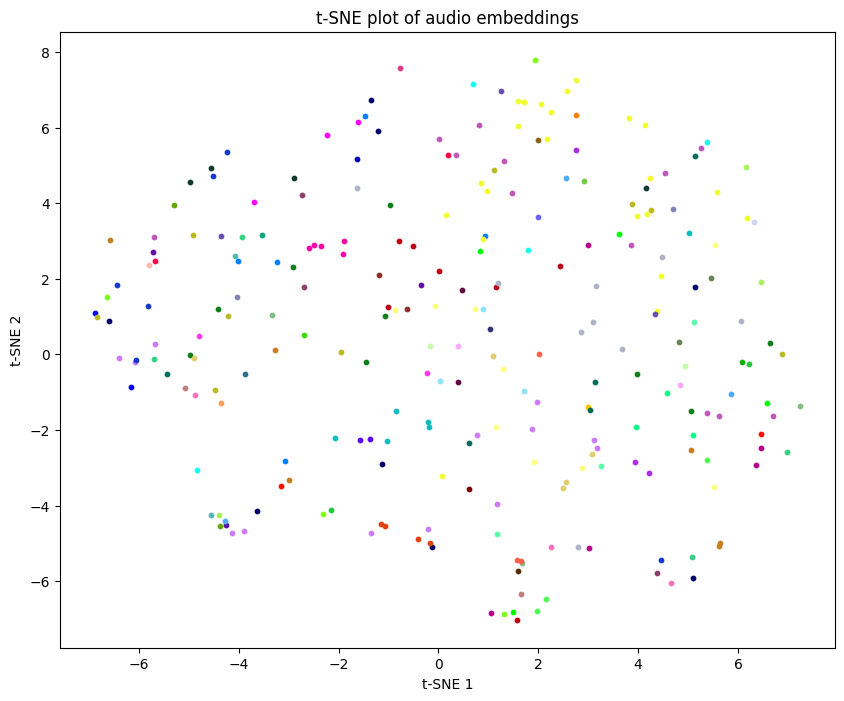

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib.colors import hsv_to_rgb
import colorsys 
import distinctipy
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from tqdm import tqdm

label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(y_test)

tsne = TSNE(n_components=2, random_state=42, perplexity=75, n_iter=5000)
embeddings_2d = tsne.fit_transform(X_test.numpy())

num_labels = len(np.unique(all_labels_encoded))
# palette = sns.color_palette("husl", num_labels) 
# color_map = {label: palette[i] for i, label in enumerate(np.unique(all_labels_encoded))}

color_map = distinctipy.get_colors(num_labels) 
# print(len(color_map))
# colors = list(mcolors.CSS4_COLORS.values())

# filtered_colors = [color for color in colors if mcolors.to_rgba_array(color)[:, :3].mean(axis=0).max() < 0.87]

# if len(filtered_colors) < num_labels:
#     print(f'colours are less by {num_labels} - {len(filtered_colors)}') 
#     filtered_colors = (filtered_colors * (num_labels // len(filtered_colors) + 1))[:num_labels]

plt.figure(figsize=(10, 8))
for i, label in enumerate(np.unique(all_labels_encoded)):
    indices = all_labels_encoded == label
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        color=color_map[label],
        label=label_encoder.inverse_transform([label])[0],
        s=10
    )

plt.title('t-SNE plot of audio embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.legend(loc='best', fontsize='small', markerscale=2, ncol=2)
plt.show()

/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


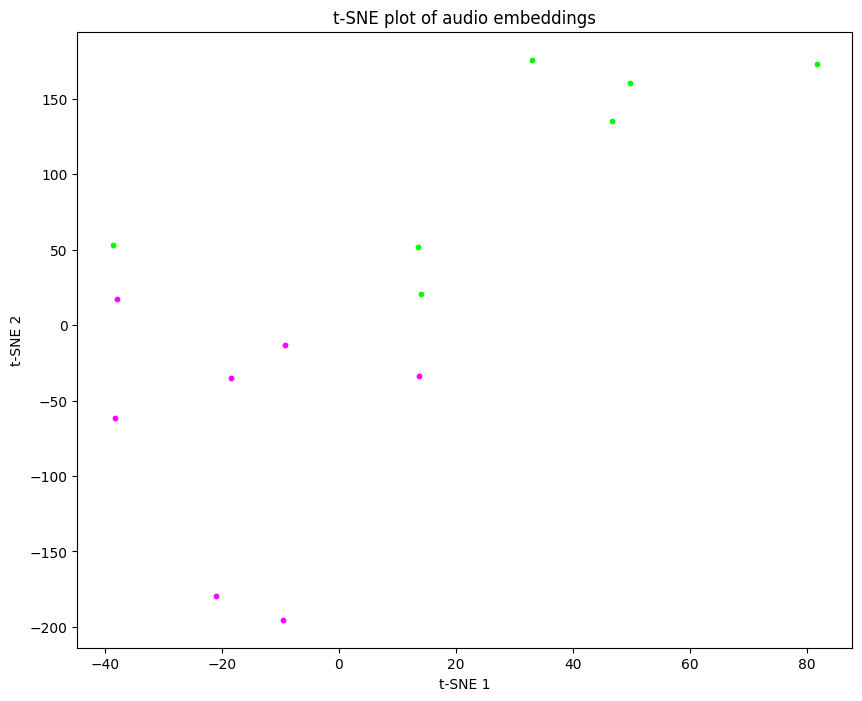

In [47]:
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels2)

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=5000)
embeddings_2d = tsne.fit_transform(all_embeddings2.numpy())

num_labels = len(np.unique(all_labels_encoded))
# palette = sns.color_palette("husl", num_labels) 
# color_map = {label: palette[i] for i, label in enumerate(np.unique(all_labels_encoded))}

color_map = distinctipy.get_colors(num_labels) 
# print(len(color_map))
# colors = list(mcolors.CSS4_COLORS.values())

# filtered_colors = [color for color in colors if mcolors.to_rgba_array(color)[:, :3].mean(axis=0).max() < 0.87]

# if len(filtered_colors) < num_labels:
#     print(f'colours are less by {num_labels} - {len(filtered_colors)}') 
#     filtered_colors = (filtered_colors * (num_labels // len(filtered_colors) + 1))[:num_labels]

plt.figure(figsize=(10, 8))
for i, label in enumerate(np.unique(all_labels_encoded)):
    indices = all_labels_encoded == label
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        color=color_map[label],
        label=label_encoder.inverse_transform([label])[0],
        s=10
    )

plt.title('t-SNE plot of audio embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.legend(loc='best', fontsize='small', markerscale=2, ncol=2)
plt.show()